### Does the Weather Affect same day Price?

In [1]:
# Libraries for data cleaning, massaging:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import datetime as dt


# Modeling Libraries
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, regularizers
from tensorflow.keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler

# Save Models
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Manipulate directories 
import os

# Import custom functions
os.chdir('../scripts')
from functions import split_data, sMAPE, SMAPE, compute_metrics, r2,impute_immediate_mean
from functions import resample, plot_metric_range, compile_fit, ensemble_nn
os.chdir('../notebooks')

In [2]:
# Import the data
df = pd.read_csv('../data/clean/df_clean.csv', parse_dates=True, index_col=0)

In [3]:
# Remove the price components cols
price_drop = df.filter(regex='price').columns.to_list()
price_drop.remove('price_actual')
df.drop(columns=price_drop, inplace=True)

Encode categorical columns

In [4]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate wind_dir_coder LabelEncoder, fit
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])

# Transform wind_direction cols
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate condition_coder LabelEncoder, fit on stacked conditions
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)

# Transform condition cols
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

Split data, train, and compute lasso

In [7]:
X_train, y_train, X_val, y_val = split_data(df, 2020, 'price_actual')

lr = Lasso(max_iter=10000, random_state=17)
lr.fit(X_train, y_train)
compute_metrics(lr, 'vanilla', (X_train, y_train), (X_val, y_val))

['vanilla', 11.187, 29.509, 0.708, 0.594]

Look at Lasso model coefficients

In [8]:
lr_coefs = pd.DataFrame({'Coefficients':lr.coef_}, index=X_val.columns)
lr_coefs['Key'] = lr_coefs.Coefficients.apply(lambda x: 'Negative' if x<0 else 'Positive')
lr_coefs.Coefficients = abs(lr_coefs.Coefficients)

In [9]:
lr_coefs.sort_values(by='Coefficients', ascending=False).head(10)

,Coefficients,Key
renewable,0.256503,Positive
dew_point_barcelona,0.065515,Negative
condition_bilbao,0.036635,Negative
other,0.031813,Positive
wind_bilbao,0.025159,Negative
wind_seville,0.022924,Negative
humidities_madrid,0.017798,Positive
biomass,0.011691,Positive
condition_barcelona,0.009297,Positive
temp_bilbao,0.008292,Negative


### Determining if the model is only noise
Let's explore if that 0.59 r-squared is just noise or the model is actually catching on to a relationship.  Below I'll use RFE to select the most important features, then run a model and display it's performance.  Next, run another model with the least most important features.  If the model with important features significantly outperforms the model with less important features, we can be sure that 0.59 r-squared is not just random noise.

To start, I'll RFE and then plot the results by number of features:

In [10]:
sMAPE_lasso = []
for i in range(1, len(X_train.columns)):
    lasso_temp = Lasso(max_iter = 10000, random_state=17)
    selector = RFE(lasso_temp, n_features_to_select=i)
    selector = selector.fit(X_train, y_train)
    cols = X_train.columns[selector.support_]
    lasso_temp.fit(X_train[cols], y_train)

    preds = lasso_temp.predict(X_val[cols])
    sMAPE_lasso.append(sMAPE(y_val, preds))

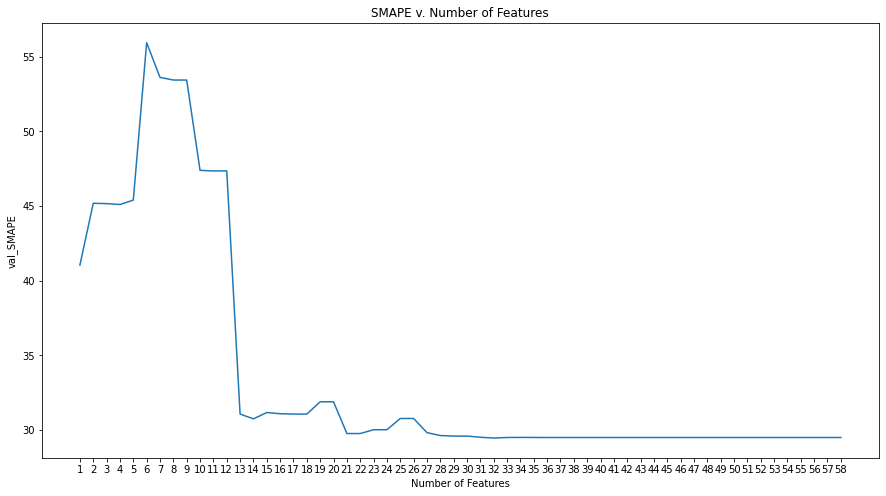

In [11]:
fig = plt.figure(figsize=(15,8))
plt.plot(range(1, len(X_train.columns)), sMAPE_lasso);
plt.xticks(range(1,len(X_train.columns)));
plt.xlabel('Number of Features');
plt.ylabel('val_SMAPE');
plt.title("SMAPE v. Number of Features");
#plt.savefig('../images/RFE_LassoRegression')

Great, it looks like model most improves when run on thetop 13 features. I'll get those top 13 features, and fit a model below and compute the metrics.

In [12]:
lasso_13 = Lasso(max_iter = 10000, random_state=17)
selector = RFE(lasso_13, n_features_to_select=13)
selector = selector.fit(X_train, y_train)
cols = X_train.columns[selector.support_]
lasso_13.fit(X_train[cols], y_train)
preds_13 = lasso_13.predict(X_val[cols])
sMAPE(y_val, preds)

29.508831211931316

Run model using "less important" columns, compute SMAPE on validation set

In [13]:
# Get the other columns not included in lasso_13
other_cols = list(set(X_train.columns.to_list()) - set(cols))

# Run model on remaining "unimportant" columns
lasso_other = Lasso(max_iter=10000)
lasso_other.fit(X_train[other_cols], y_train)
preds_other = lasso_other.predict(X_val[other_cols])
sMAPE(y_val, preds_other)

24.61709112931429

lasso_other model with "less" important features actually performs better than model run on "more" important features.

**Conclusion**: Without the `price_day_ahead` variable, our other columns are mostly just noisy, having little information on the current day's price.

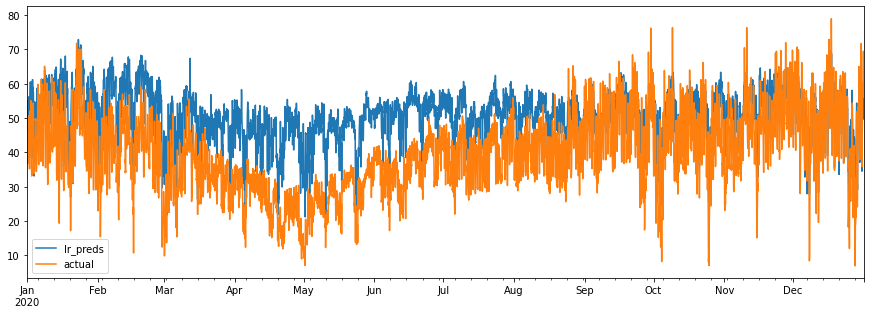

In [28]:
df_preds = pd.DataFrame({'lr_preds':lr_preds, 'actual':y_val})
df_preds.plot(figsize=(15,5));

Fit XGBoost Regressor and compute metrics

In [6]:
x = XGBRegressor()
x.fit(X_train, y_train)
compute_metrics(x, 'vanilla', (X_train, y_train), (X_val, y_val))

['vanilla', 4.035, 26.849, 0.959, 0.417]

Scale categorical data for neural networks

In [7]:
# Copy the dataframe for neural networks
df_nn = df.copy()
continuous = df_nn.select_dtypes(exclude='object').filter(regex='^(?!.*price).*').columns

# Get rid of negatives
time = dt.datetime(2021,3,24,22)
df_nn.loc[time, 'dew_point_bilbao'] = impute_immediate_mean(df_nn['dew_point_bilbao'], time)

# Rescale data [-1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_nn[continuous] = scaler.fit_transform(df_nn[continuous])

Define simple neural net, compile, fit, and compute metrics

In [8]:
# Define input_shape
input_shape = (X_train.shape[1],)

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(layers.Dense(1, activation='relu'))

# Compile and Fit
nn10 = compile_fit(nn, (X_train,y_train), (X_val, y_val), patience=10,
                  loss = tf.keras.metrics.mean_absolute_error)

# Compute metrics, add to table
compute_metrics(nn10, '1-to-1', (X_train,y_train), (X_val, y_val))

Epoch 1/200
1370/1370 [==============================] - 2s 2ms/step - loss: 56.7885 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 2/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7886 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 3/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7886 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 4/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7886 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 5/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7886 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 6/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7885 - SMAPE: 200.0000 - val_loss: 39.1089 - val_SMAPE: 200.0000
Epoch 7/200
1370/1370 [==============================] - 2s 1ms/step - loss: 56.7886 - SMAPE: 200.0000 - val_loss: 39.1089 - val_S

C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\holde\anaconda3\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


['1-to-1', 200.0, 200.0, nan, nan]

Neural network 24-to-24

In [9]:
# Split Data
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24, 24, 24)
X_val, y_val = resample((X_val,y_val), 24, 24, 24)

# Define input_shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile and Fit
nn3 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics and add to table
compute_metrics(nn3, '24-to-24', (X_train,y_train), (X_val, y_val))

Epoch 1/200
58/58 [==============================] - 1s 6ms/step - loss: 26.2745 - SMAPE: 72.2827 - val_loss: 14.5480 - val_SMAPE: 33.6830
Epoch 2/200
58/58 [==============================] - 0s 4ms/step - loss: 7.2611 - SMAPE: 14.0760 - val_loss: 10.5521 - val_SMAPE: 26.0518
Epoch 3/200
58/58 [==============================] - 0s 4ms/step - loss: 6.7586 - SMAPE: 12.8824 - val_loss: 10.9245 - val_SMAPE: 26.5871
Epoch 4/200
58/58 [==============================] - 0s 4ms/step - loss: 6.4132 - SMAPE: 12.0346 - val_loss: 13.1368 - val_SMAPE: 30.7375
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 6.2548 - SMAPE: 11.7899 - val_loss: 9.1679 - val_SMAPE: 23.0653
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 6.2105 - SMAPE: 11.5716 - val_loss: 10.1062 - val_SMAPE: 24.9829
Epoch 7/200
58/58 [==============================] - 0s 4ms/step - loss: 5.7861 - SMAPE: 10.7788 - val_loss: 10.9657 - val_SMAPE: 26.7102
Epoch 8/200
58/58 [===============

['24-to-24', 11.72, 23.572, 0.702, 0.54]

LSTM network

In [10]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Reorganize the training and testing data into batches
X_train, y_train = resample((X_train, y_train), 24*7, 24, 24)
X_val, y_val = resample((X_val,y_val), 24*7, 24, 24)

# Input Shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Instantiate model and build layers
nn = models.Sequential()
nn.add(layers.LSTM(60, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))

# Compile Fit
nn4 = compile_fit(nn, (X_train, y_train), (X_val, y_val))

# Compute metrics, add to table
compute_metrics(nn4, 'LSTM, 7-day input', (X_train,y_train), (X_val,y_val))

Epoch 1/200
58/58 [==============================] - 6s 67ms/step - loss: 52.2956 - SMAPE: 168.9717 - val_loss: 31.8128 - val_SMAPE: 133.0735
Epoch 2/200
58/58 [==============================] - 3s 60ms/step - loss: 48.5411 - SMAPE: 146.3428 - val_loss: 29.9475 - val_SMAPE: 119.6757
Epoch 3/200
58/58 [==============================] - 4s 62ms/step - loss: 46.8424 - SMAPE: 137.2450 - val_loss: 28.3482 - val_SMAPE: 109.1294
Epoch 4/200
58/58 [==============================] - 4s 63ms/step - loss: 45.2719 - SMAPE: 128.8193 - val_loss: 26.8187 - val_SMAPE: 99.7285
Epoch 5/200
58/58 [==============================] - 4s 72ms/step - loss: 43.7509 - SMAPE: 121.8019 - val_loss: 25.3340 - val_SMAPE: 91.1839
Epoch 6/200
58/58 [==============================] - 4s 76ms/step - loss: 42.2629 - SMAPE: 114.7334 - val_loss: 23.8848 - val_SMAPE: 83.3453
Epoch 7/200
58/58 [==============================] - 4s 73ms/step - loss: 40.7986 - SMAPE: 108.4918 - val_loss: 22.4738 - val_SMAPE: 76.1527
Epoch 8/20

['LSTM, 7-day input', 38.736, 24.2, 0.006, 0.007]

DNN-LSTM

In [17]:
# Split the data into train and validation
X_train, y_train, X_val, y_val = split_data(df_nn, 2020, 'price_actual')

# Get the x cols for lstm network, lagged cols
X_train_dnn = X_train.filter(regex='forecast')
X_train_lstm = X_train.drop(columns=X_train_dnn.columns)


# Get the x cols for dnn network, forecast cols
X_val_dnn = X_val.filter(regex='forecast')
X_val_lstm = X_val.drop(columns=X_val_dnn.columns)


# Reorganize the training and testing data into batches
X_train_dnn, y_train_dnn = resample((X_train_dnn, y_train), 24, 24, 24)
X_val_dnn, y_val_dnn = resample((X_val_dnn, y_val), 24, 24, 24)

# LSTM
X_train_lstm, y_train_lstm = resample((X_train_lstm, y_train), 24, 24, 24)
X_val_lstm, y_val_lstm = resample((X_val_lstm, y_val), 24, 24, 24)

# Instantiate, compiled and fit dnn
input_shape = (X_train_dnn.shape[1], X_train_dnn.shape[2])
nn = models.Sequential()
nn.add(layers.Dense(59, activation='relu', input_shape=input_shape))
nn.add(layers.Dense(239, activation='relu'))
nn.add(layers.Dense(162, activation='relu'))
nn.add(TimeDistributed(layers.Dense(1)))
dnn = compile_fit(nn, (X_train_dnn, y_train_dnn), (X_val_dnn, y_val_dnn))


# Instantiate, compiled and fit lstm
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
nn = models.Sequential()
nn.add(layers.LSTM(83, activation='tanh', input_shape=input_shape))
nn.add(layers.RepeatVector(y_train_lstm.shape[1]))
nn.add(layers.LSTM(24, activation='tanh', return_sequences=True))
nn.add(TimeDistributed(layers.Dense(1)))
lstm = compile_fit(nn, (X_train_lstm, y_train_lstm), (X_val_lstm, y_val_lstm))

# Create ensemble to combine dnn and lstm, compile and fit
LSTM_DNN = ensemble_nn([dnn, lstm])
nn6 = compile_fit(LSTM_DNN, ([X_train_dnn, X_train_lstm], y_train_dnn), ([X_val_dnn, X_val_lstm], y_val_dnn))

# Compute metrics, add to table
compute_metrics(nn6,
                'dnn-lstm, 1-day input',
                ([X_train_dnn, X_train_lstm],y_train),
                ([X_val_dnn, X_val_lstm],y_val))

Epoch 1/200
58/58 [==============================] - 1s 6ms/step - loss: 36.5175 - SMAPE: 108.6519 - val_loss: 11.9756 - val_SMAPE: 28.4987
Epoch 2/200
58/58 [==============================] - 0s 4ms/step - loss: 7.8168 - SMAPE: 14.8408 - val_loss: 14.2115 - val_SMAPE: 32.1070
Epoch 3/200
58/58 [==============================] - 0s 4ms/step - loss: 7.6294 - SMAPE: 14.6597 - val_loss: 13.2966 - val_SMAPE: 30.5499
Epoch 4/200
58/58 [==============================] - 0s 4ms/step - loss: 7.7165 - SMAPE: 14.6538 - val_loss: 14.0084 - val_SMAPE: 31.7661
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 7.5364 - SMAPE: 14.2818 - val_loss: 14.7610 - val_SMAPE: 33.0473
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 7.4967 - SMAPE: 14.3276 - val_loss: 15.8258 - val_SMAPE: 34.9478
Epoch 7/200
58/58 [==============================] - 0s 4ms/step - loss: 7.4726 - SMAPE: 14.2172 - val_loss: 14.5819 - val_SMAPE: 32.7343
Epoch 8/200
58/58 [=============

['dnn-lstm, 1-day input', 15.992, 31.549, 0.46, 0.365]